In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
import os
import pickle

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio") # Filter out a standard warning
import lal
import lalsimulation as LS

### Data Generation
In this tutorial, we will train a normalizing flow to estimate the posterior over the masses of gravitational waves.
For the training, we need a large dataset of simulated data which we will create in this notebook.

This notebook will:
- provide more details about the parameters that can be passed to the waveform model
- explain how waveforms can be generated
- include code to generate a dataset for training

Parts of this code are based on the tutorial [GW Parameter Inference with Machine Learning](https://github.com/stephengreen/gw-school-corfu-2023/tree/main) by Stephen R. Green.

### Parameters of a gravitational waves simulator

Most gravitational waves that are detected currently by the Ligo-Virgo-KAGRA collaboration are signals orginating from the merger of two black holes. These systems can be described by the following parameters:
- Masses of both black holes $m_1$ and $m_2$ (2 parameters) and their spins (6 parameters)
- Inclination
- Sky position (2 parameters)
- Luminosity distance
- Time of arrival
- Polarization
- Phase
which results in a 15-dimensional parameter space.
We will summarize all these parameters with $\theta$.

In general, it is the goal of gravitational wave analysis to obtain accurate joint estimates of these parameters based on the measured strain signal $h_I(\theta)$ in detector $I$.

Since it is quite challenging to train a model on the full 15-dimensional distribution, we will restrict ourselves to just two parameters: The two black hole masses.

We set all other parameters to fixed values in the data generation.

### Sampling mass values:
To generate waveforms, we first have to select reasonable values for the masses which we sample uniformly in $[20, 80] M_\odot$:

In [2]:
# Size of the training set
num_samples = 10000

# We sample the masses over a uniform prior
m_lower = 20.0  # solar masses
m_upper = 80.0
masses = m_lower + np.random.random((num_samples, 2)) * (m_upper - m_lower)

# Make sure that the masses are sorted: m1 > m2
masses = np.sort(masses, axis=-1)
masses = np.flip(masses, axis=-1)

We set the fixed values:

In [3]:
# Fixed parameters
distance = 1000  # Mpc
inclination = 0.0  # face on
spin1x = 0.0
spin1y = 0.0
spin1z = 0.0
spin2x = 0.0
spin2y = 0.0
spin2z = 0.0
phase = 0.0

### Waveform simulator
Next, we have to specify how we want to simulate the waveforms. For this, we have to choose:
- what type of waveform generator we want to use. We select `IMRPhenomPv2` since it is computationally efficient and sufficient for this tutorial. `IMRPhenomPv2` simulates the inspiral, merger, and ringdown phase of the binary black hole (BBH) in frequency domain and includes precession effects by a single-spin approximation [[1]](https://arxiv.org/abs/1809.10113).
- which frequency range to choose for the signal. Since `IMRPhenomPv2` models the waveform in frequency domain, we have to select a minimal and maximal frequency, as well as the duration of the signal in time domain (which determines $\Delta f$ in frequency domain). From these values, we can compute the number of bins in frequency domain.

In [4]:
# Waveform settings
approximant = 'IMRPhenomPv2'
f_min = 20.0
f_max = 512.0
T = 2.0

delta_f = 1 / T
nf = int(f_max / delta_f) + 1
f_array = np.linspace(0.0, f_max, num=nf)

With this information, we can run the simulator to generate a first example waveform.
Gravitational waves have a 'plus' and 'cross' polarization component, usually denoted by $h_+$ and $h_\times,$ each with real and imaginary part.



In [5]:
mass1_lal = masses[0,0] * lal.MSUN_SI # ensure correct units
mass2_lal = masses[0,1] * lal.MSUN_SI
distance_lal = distance * 1e6 * lal.PC_SI
approximant_lal = LS.GetApproximantFromString(approximant)

hp, hc = LS.SimInspiralFD(
    mass1_lal, mass2_lal,
    spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, 
    distance_lal, inclination, phase,
    0.0, 0.0, 0.0,  # longAscNodes, eccentricity, meanPerAno
    delta_f, f_min, f_max, 20.0,  # f_ref
    None,
    approximant_lal,
)

# Calculate the time shift when the simulated signal was 'recorded'
dt = 1 / hp.deltaF + (hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds * 1e-9)
time_shift = np.exp(-1j * 2 * np.pi * dt * f_array)
# Extract the plus and cross polarization 
hp_non_shifted = hp.data.data # h_plus
hc_non_shifted = hc.data.data # h_cross
# Apply the time-shift to the signal
hp = hp_non_shifted * time_shift
hc = hc_non_shifted * time_shift
# Set values below f_min to zero
hp[:int(f_min/delta_f)] = 0.0
hc[:int(f_min/delta_f)] = 0.0

Let's plot our first waveform described by the real and imaginary parts of $h_+$ and $h_\times$ in frequency domain:

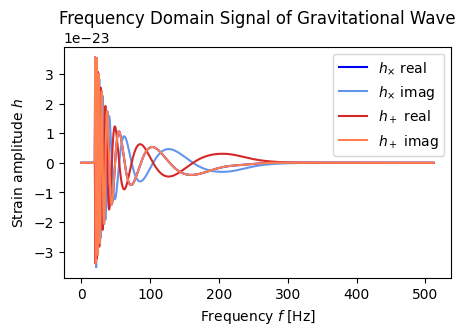

In [6]:
plt.figure(figsize=(5,3))
plt.plot(f_array, hc.real, c="blue", label=r'$h_{\times}$ real')
plt.plot(f_array, hc.imag, c="cornflowerblue", label=r'$h_{\times}$ imag')
plt.plot(f_array, hp.real, c="tab:red", label=r'$h_+$ real')
plt.plot(f_array, hp.imag, c="coral", label=r'$h_+$ imag')
plt.xlabel(r"Frequency $f$ [Hz]")
plt.ylabel(r"Strain amplitude $h$")
#plt.xscale('log')
plt.title('Frequency Domain Signal of Gravitational Wave')
plt.legend();

To visualize the same signal in time-domain, we apply the inverse Fourier transform to the (not-shifted) waveform:

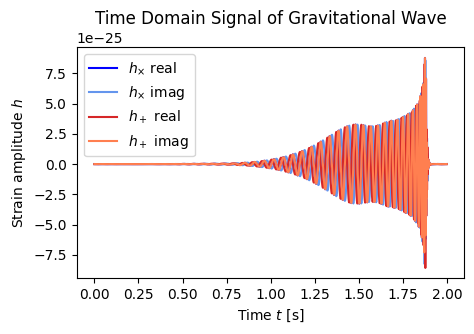

In [7]:
# Apply the inverse FFT
hc_t = scp.fft.ifft(hc_non_shifted)
hp_t = scp.fft.ifft(hp_non_shifted)
# Calculate the times
dt = T / nf
t_array = np.arange(0, nf * dt, dt)

plt.figure(figsize=(5,3))
plt.plot(t_array, hc_t.real, c="blue", label=r'$h_{\times}$ real')
plt.plot(t_array, hc_t.imag, c="cornflowerblue", label=r'$h_{\times}$ imag')
plt.plot(t_array, hp_t.real, c="tab:red", label=r'$h_+$ real')
plt.plot(t_array, hp_t.imag, c="coral", label=r'$h_+$ imag')
plt.xlabel(r'Time $t$ [s]')
plt.ylabel(r"Strain amplitude $h$")
plt.legend()
plt.title('Time Domain Signal of Gravitational Wave');

### Noise level
- Of course, this signal is not exactly what would be measured in a detector! We are still missing the noise.
- Gravitational wave interferometers (such as e.g. LIGO) measure different noise levels at different frequencies, i.e. they have a different sensitivity at different frequencies. This detector-specific information is called a "design sensitivity" or "design curve". We choose the LIGO detector for this tutorial.
- The amount of noise at a specific frequency is described by the power spectral density (PSD) (or the amplitude spectral density (ASD) where $\mathrm{ASD} = \sqrt{\mathrm{PSD}}$).

In [8]:
# Generate the noise PSD. We take this to be the LIGO design sensitivity.
lalseries = lal.CreateREAL8FrequencySeries('', lal.LIGOTimeGPS(0), 0, delta_f, lal.DimensionlessUnit, nf)
LS.SimNoisePSD(lalseries, 0, LS.SimNoisePSDaLIGOZeroDetHighPowerPtr)
psd = lalseries.data.data
psd[:int(f_min/delta_f)] = 1 # Set values below f_min to a constant factor of 1.
psd[-1] = psd[-2]
# Calculate ASD
asd = np.sqrt(psd)

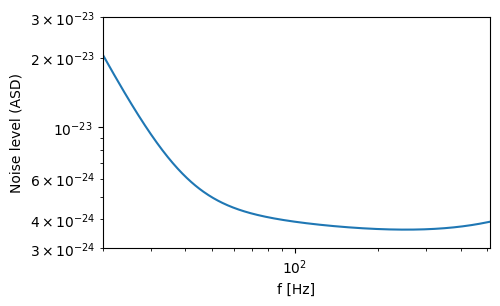

In [9]:
# Plot the ASD.
plt.figure(figsize=(5, 3))
plt.plot(f_array, asd)
plt.xlim((f_min, f_max))
plt.ylim((3e-24, 3e-23))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Noise level (ASD)')
plt.show()

This noise information can be combined with the waveform by "whitening" of the signal, after which the data is rescaled such that the white noise has unit variance in each frequency bin. (This makes it easy to add noise and has the nice side effect that the data is normalized which is better for a neural network input).

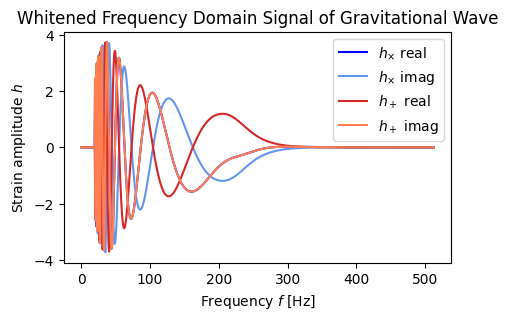

In [10]:
hp = hp / asd * np.sqrt(4.0 * delta_f)
hc = hc / asd * np.sqrt(4.0 * delta_f)

plt.figure(figsize=(5,3))
plt.plot(f_array, hc.real, c="blue", label=r'$h_{\times}$ real')
plt.plot(f_array, hc.imag, c="cornflowerblue", label=r'$h_{\times}$ imag')
plt.plot(f_array, hp.real, c="tab:red", label=r'$h_+$ real')
plt.plot(f_array, hp.imag, c="coral", label=r'$h_+$ imag')
plt.xlabel(r"Frequency $f$ [Hz]")
plt.ylabel(r"Strain amplitude $h$")
#plt.xscale('log')
plt.title('Whitened Frequency Domain Signal of Gravitational Wave')
plt.legend();

Now, we understand all components that are needed to generate a training data set:

In [11]:
# Generate waveforms for training data set

hp_list = []
hc_list = []

for i in range(num_samples):
    
    mass1, mass2 = masses[i]

    mass1_lal = mass1 * lal.MSUN_SI
    mass2_lal = mass2 * lal.MSUN_SI
    distance_lal = distance * 1e6 * lal.PC_SI
    approximant_lal = LS.GetApproximantFromString(approximant)

    hp, hc = LS.SimInspiralFD(
        mass1_lal, mass2_lal,
        spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, 
        distance_lal, inclination, phase,
        0.0, 0.0, 0.0,  # longAscNodes, eccentricity, meanPerAno
        delta_f, f_min, f_max, 20.0,  # f_ref
        None,
        approximant_lal,
    )

    dt = 1 / hp.deltaF + (hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds * 1e-9)
    time_shift = np.exp(-1j * 2 * np.pi * dt * f_array)
    
    hp = hp.data.data
    hc = hc.data.data

    hp *= time_shift
    hc *= time_shift
    
    hp[:int(f_min/delta_f)] = 0.0
    hc[:int(f_min/delta_f)] = 0.0
    
    # Whiten waveforms and rescale so that white noise has unit variance in each frequency bin.
    # This makes it easy to add noise, and also normalized data works better as input to neural networks.
    
    hp = hp / asd * np.sqrt(4.0 * delta_f)
    hc = hc / asd * np.sqrt(4.0 * delta_f)
    
    hp_list.append(hp)
    hc_list.append(hc)

hp = np.array(hp_list)
hc = np.array(hc_list)

In [12]:
fixed_params = {'dist':distance, 'incl':inclination, 's1x':spin1x, 's1y':spin1y, 's1z':spin1z, 's2x':spin2x, 's2y':spin2y, 's2z':spin2z, 'phi':phase}

# Get the absolute path of the directory where the notebook is located
print("Current working directory", os.getcwd())
data_folder = os.path.join(os.getcwd(), 'genAI-Days/01_normalizing_flows/data')
file_name = os.path.join(data_folder, 'dataset.pkl')

if not os.path.isdir(data_folder):
    raise ValueError(f"Folder {data_folder} does not exist, correct path.")

data_dict = {'hp':hp, 'hc':hc, 'masses':masses, 'f_min':f_min, 'f_max':f_max, 'T':T}
with open(file_name, 'wb') as f:
    pickle.dump(data_dict, f)
print('Saved dataset to', file_name)

Current working directory /Users/akofler/Desktop/courses_and_tutorials/2024_genAI_days_ODSL
Saved dataset to /Users/akofler/Desktop/courses_and_tutorials/2024_genAI_days_ODSL/genAI-Days/01_normalizing_flows/data/dataset.pkl
